In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
# Data Loader
csf_data = pd.read_csv("merged_csf_cross_sectional_call_rate_pau_data_0205.xls", low_memory=False)
plasma_data = pd.read_csv("merged_plasma_cross_sectional_call_rate_data_0130.xls", low_memory=False)

In [3]:
plasma_data['Status_at_draw_mapping'].value_counts()

Status_at_draw_mapping
CO     1282
AD      865
PD      687
DLB     122
FTD      44
Name: count, dtype: int64

In [4]:
# plasma_data

In [5]:
csf_significant_rows = pd.read_csv("csf_significant_rows_0205.csv")
plasma_significant_rows = pd.read_csv("plasma_significant_rows_0203.csv")

### Data Loader

In [6]:
data = csf_data.copy()
print(data.shape)

(4677, 3667)


In [7]:
x_columns = [col for col in csf_data.columns if col.startswith('X')]
len(x_columns)

3622

In [8]:
protein_list = list(csf_significant_rows['Analytes'])
print(len(protein_list))
# protein_list

3020


In [9]:
data['Status_at_draw'].value_counts()

Status_at_draw
CO                                 1534
AD                                 1163
PD                                  738
Prodromal                           332
OT                                  266
ADAD_Presymptomatic_carrier         184
ADAD_Unaffected_Non_carrier         184
ADAD_Affected_carrier               114
FTD                                  39
DLB                                  37
MCI                                  21
PDD                                  13
Unknown                               8
Dystonia                              8
ADAD_Affected_Non_carrier             5
AD vs FTD                             3
MSA                                   3
MCI-PD                                3
PGRN_Unaffected_Non_carrier           2
MAPT_Presymptomatic_carrier           2
FTD+MCI                               2
E.Tremor                              1
C9ORF72_Affected_carrier              1
PGRN_Presymptomatic_carrier           1
FTD+Parkinsonism         

In [10]:
data['Project_y'].value_counts()

Project_y
PPMI        1075
MAP         1055
ADNI         737
Ruiz         620
DIAN         482
Stanford     264
PD           238
Pau          206
Name: count, dtype: int64

In [17]:
filtered_data = data.copy()
print(filtered_data.shape)

(4677, 3667)


### LightGBM Model Performance

In [19]:
import joblib
csf_lgbm_model = joblib.load("csf_model_output/csf_lgbm_model_400_0411.pkl")
# csf_lgbm_model = joblib.load("plasma_model_output/plasma_lgbm_model_700_0411.pkl")

In [18]:
with open("csf_model_output/csf_selected_features_400_0411.txt", "r") as f:
# with open("plasma_model_output/plasma_selected_features_700_0411.txt", "r") as f:
    csf_selected_features = [line.strip() for line in f.readlines()]

existing_features = [feature for feature in csf_selected_features if feature in filtered_data.columns]
selected_data = filtered_data[existing_features]

print(f"Total selected features: {len(csf_selected_features)}")
print(f"Existing features in dataset: {len(existing_features)}")

Total selected features: 400
Existing features in dataset: 400


In [20]:
print(filtered_data.shape)
print(selected_data.shape)

(4677, 3667)
(4677, 400)


In [24]:
X_new = selected_data.iloc[:, :]

y_pred = csf_lgbm_model.predict(X_new)
y_pred_proba = csf_lgbm_model.predict_proba(X_new)

print("Predicted Labels:", y_pred)
print("Predicted Probabilities:\n", y_pred_proba)

Predicted Labels: [1 1 1 ... 0 4 1]
Predicted Probabilities:
 [[3.69076428e-07 9.99980825e-01 1.83863623e-07 2.14935993e-07
  1.84067700e-05]
 [1.17707941e-06 9.99992655e-01 9.79554428e-08 4.95145571e-06
  1.11835874e-06]
 [6.94649227e-06 9.99591584e-01 2.82768404e-07 3.31747144e-06
  3.97869663e-04]
 ...
 [7.52778019e-01 2.89392044e-02 1.36450627e-03 3.13534079e-04
  2.16604736e-01]
 [5.25158089e-04 3.43183101e-01 5.02806732e-05 3.01394887e-05
  6.56211321e-01]
 [1.25721058e-02 4.99931936e-01 3.59101509e-04 4.62383125e-04
  4.86674474e-01]]


In [28]:
status_labels = filtered_data['Status_at_draw'].str.upper()
y_pred_proba_df = pd.DataFrame(y_pred_proba, index=status_labels.index, columns=[f"{label} Probability" for label in ['AD', 'CO', 'DLB', 'FTD', 'PD']])
predicted_classes = y_pred_proba_df.idxmax(axis=1).str.replace(' Probability', '')

results_df = pd.DataFrame({
    "UniquePhenoID": filtered_data['UniquePhenoID'],
    "DrawDate": filtered_data['DrawDate'],
    "Project_y": filtered_data['Project_y'],
    "Status_at_draw": filtered_data['Status_at_draw'].str.upper(),
    "Status_at_draw_mapping": filtered_data['Status_at_draw_mapping'],
    "Final_Status": filtered_data['Final_Status'],
    "Age_at_draw": filtered_data['Age_at_draw'],
    "Age_onset": filtered_data['Age_onset'],
    "Age_at_last": filtered_data['Age_at_last'],
    "Sex": filtered_data['Sex'],
    "Final_Status_Data": filtered_data['Last_CDR_testdate'],
    "AT Status": filtered_data['AT_class'],
    "ATN_DrawDate": filtered_data['ATN_drawdate'],
    "Amyloid PET Imaging": filtered_data['final_decision'],
    "PET_DrawDate": filtered_data['PET_Date'],
    "ptau217": filtered_data['T1_pTau217'],
    "ptau217_DrawDate": filtered_data["T1T2_DrawDate"],
    "CDR_score_closest": filtered_data['CDR_score_closest'],
    "Last_CDR_score": filtered_data['Last_CDR_score'],
    # "Predicted Class": label_encoder.inverse_transform(y_pred)
    "Predicted Class": predicted_classes
})

results_df = pd.concat([results_df, y_pred_proba_df], axis=1)
# results_df

# results_df.to_csv("csf_status_predictions_4677_400_0522.csv", index=False)
# results_df.to_csv("plasma_status_predictions_4750_700_0523.csv", index=False)

In [32]:
results_df['Status_at_draw'].value_counts()

Status_at_draw
CO                                 1534
AD                                 1163
PD                                  738
PRODROMAL                           332
OT                                  266
ADAD_PRESYMPTOMATIC_CARRIER         184
ADAD_UNAFFECTED_NON_CARRIER         184
ADAD_AFFECTED_CARRIER               114
FTD                                  39
DLB                                  37
MCI                                  21
PDD                                  13
UNKNOWN                               8
DYSTONIA                              8
ADAD_AFFECTED_NON_CARRIER             5
AD VS FTD                             3
MSA                                   3
MCI-PD                                3
PGRN_UNAFFECTED_NON_CARRIER           2
MAPT_PRESYMPTOMATIC_CARRIER           2
FTD+MCI                               2
E.TREMOR                              1
C9ORF72_AFFECTED_CARRIER              1
PGRN_PRESYMPTOMATIC_CARRIER           1
FTD+PARKINSONISM         

### Single Category Radar Plot

In [29]:
def calculate_mean_and_ci(data, confidence=0.95):
    mean = np.mean(data, axis=0)
    se = np.std(data, axis=0) / np.sqrt(len(data))
    ci = se * 1.96  # 95% CI
    return mean, mean - ci, mean + ci

In [30]:
def plot_radar_chart(mean, lower_ci, upper_ci, title):
    # Extract class labels by removing ' Probability' from column names
    labels = [col.replace(' Probability', '') for col in results_df.columns if 'Probability' in col]
    num_vars = len(labels)

    # Compute angles for each axis on the radar chart
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Close the loop

    # Initialize the radar chart figure
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Repeat the first value to close the radar shape
    mean_values   = list(mean) + [mean[0]]
    lower_ci_vals = list(lower_ci) + [lower_ci[0]]
    upper_ci_vals = list(upper_ci) + [upper_ci[0]]

    # Plot the mean and confidence interval lines
    ax.fill(angles, mean_values, color='#1f77b4', alpha=0.25)
    ax.plot(angles, mean_values, color='#1f77b4', linewidth=2, linestyle='solid', label='Mean')
    ax.plot(angles, lower_ci_vals, color='#1f77b4', linewidth=2, linestyle='dashed', label='95% CI')
    ax.plot(angles, upper_ci_vals, color='#1f77b4', linewidth=2, linestyle='dashed')

    # Configure the axis and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=28, fontweight='bold')
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=18, fontweight='bold')

    # Highlight only the direction with the highest mean value
    idx_max = int(np.argmax(mean))

    # Annotate only the max mean value (no CI shown)
    ax.text(angles[idx_max], mean_values[idx_max] + 0.05,
            f'{mean_values[idx_max]:.2f}',
            ha='center', va='center',
            fontsize=28, fontweight='bold', color='black')

    # (Commented out: CI annotations)
    # ax.text(angles[idx_max], lower_ci_vals[idx_max] - 0.05, f'{lower_ci_vals[idx_max]:.2f}', ...)
    # ax.text(angles[idx_max], upper_ci_vals[idx_max] + 0.03, f'{upper_ci_vals[idx_max]:.2f}', ...)

    # Show the plot
    # plt.title(title, fontsize=20, fontweight='bold', y=1.08)  # optional
    plt.tight_layout()
    plt.show()

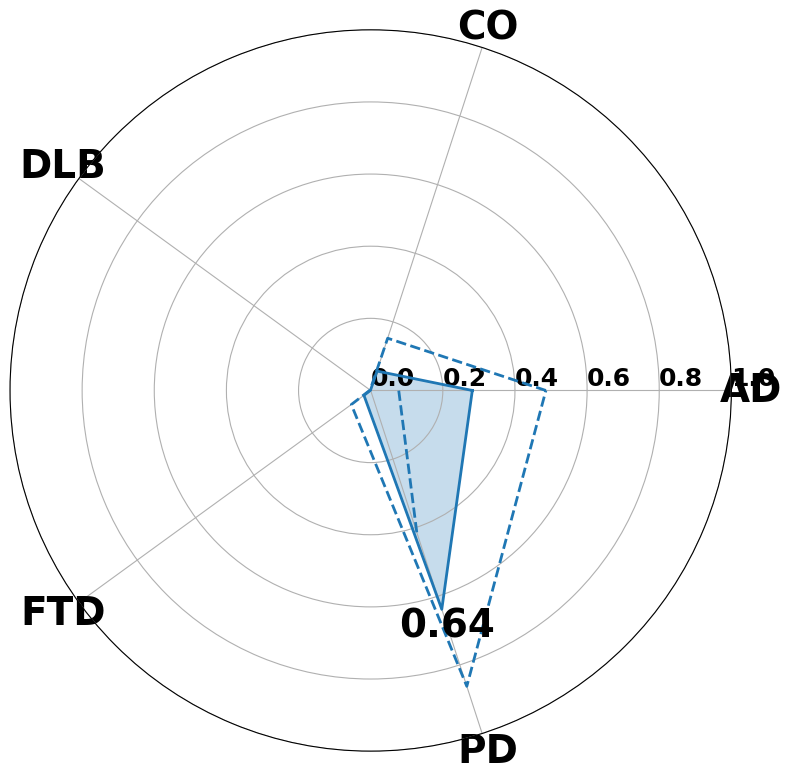

In [37]:
# Loop over target classes to create radar plots for each
# for true_class in ['ADAD_AFFECTED_CARRIER']:  # You can add more classes here
for true_class in ['PDD']:  # You can add more classes here
    # Filter the dataset to get only samples of the selected class
    subset = results_df[results_df['Status_at_draw'] == true_class]

    # Extract probability columns as NumPy array
    probabilities = subset[[col for col in results_df.columns if 'Probability' in col]].values

    # Compute mean and 95% CI
    mean, lower_ci, upper_ci = calculate_mean_and_ci(probabilities)

    # Generate radar chart
    plot_radar_chart(mean, lower_ci, upper_ci, f'Radar Plot for {true_class}')

### Neuralpathological Trail and Cognitive Tests

(2267, 6)


C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31032\2139423974.py:21: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


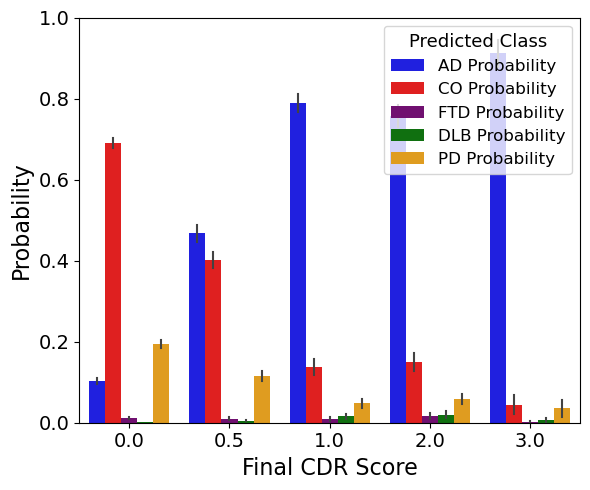

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_vars = ['AD Probability', 'CO Probability', 'FTD Probability', 'DLB Probability', 'PD Probability']
colors = ['blue', 'red', 'purple', 'green', 'orange']
palette = dict(zip(y_vars, colors))

categorical_vars = [
    'Last_CDR_score'
]

for var in categorical_vars:
    plot_data = results_df[[var] + y_vars].dropna()
    print(plot_data.shape)
    plot_data_melted = plot_data.melt(id_vars=var, value_vars=y_vars, 
                                      var_name='Prediction', value_name='Probability')

    plt.figure(figsize=(6, 5))
    sns.barplot(
        data=plot_data_melted,
        x=var,
        y='Probability',
        hue='Prediction',
        estimator=np.mean,
        errorbar=('se'),
        palette=palette,
        errwidth=1.5
    )

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1)
    # plt.title(f'{cat_var}', fontsize=18, fontweight='bold')
    plt.xlabel("Final CDR Score", size=16)
    plt.ylabel('Probability', size=16)
    plt.legend(title='Predicted Class', loc='upper right', fontsize=12, title_fontsize=13)
    plt.tight_layout()
    plt.show()

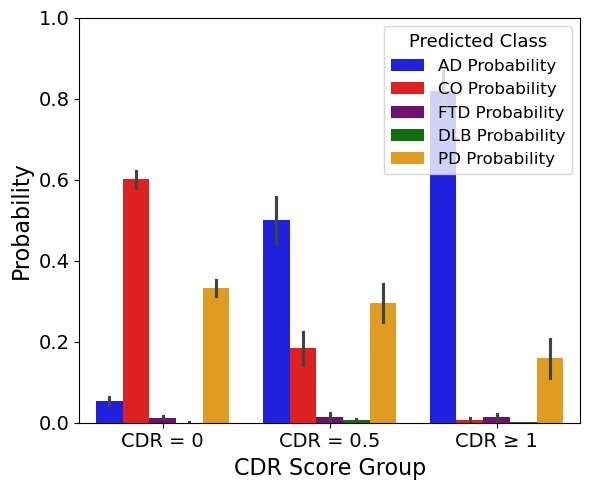

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

subset = results_df[results_df['Status_at_draw'].isin([
    'ADAD_AFFECTED_CARRIER', 'ADAD_PRESYMPTOMATIC_CARRIER', 'ADAD_UNAFFECTED_NON_CARRIER'
])]

required_cols = ['CDR_score_closest', 'AD Probability', 'CO Probability', 'PD Probability', 'FTD Probability', 'DLB Probability']
subset = subset.dropna(subset=required_cols)

def bin_cdr(score):
    if score == 0:
        return 'CDR = 0'
    elif score == 0.5:
        return 'CDR = 0.5'
    else:
        return 'CDR ≥ 1'

subset['CDR_group'] = subset['CDR_score_closest'].apply(bin_cdr)

melted = subset.melt(
    id_vars='CDR_group',
    value_vars=['AD Probability', 'CO Probability', 'FTD Probability', 'DLB Probability', 'PD Probability'],
    var_name='Status',
    value_name='Probability'
)

melted['CDR_group'] = pd.Categorical(
    melted['CDR_group'],
    categories=['CDR = 0', 'CDR = 0.5', 'CDR ≥ 1'],
    ordered=True
)

color_map = {
    'AD Probability': 'blue',
    'CO Probability': 'red',
    'FTD Probability': 'purple',
    'DLB Probability': 'green',
    'PD Probability': 'orange'
}

plt.figure(figsize=(6, 5))
sns.barplot(
    data=melted,
    x='CDR_group',
    y='Probability',
    hue='Status',
    palette=color_map,
    estimator=np.mean,
    errorbar='se'
)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 1)
# plt.title("ADAD Affected & Unaffected: CDR Score", fontsize=18, fontweight='bold')
plt.xlabel("CDR Score Group", size=16)
plt.ylabel("Probability", size=16)
plt.legend(title='Predicted Class', loc='upper right', fontsize=12, title_fontsize=13)
# plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()